이것은 매우 흥미로운 작업이며 초보자에게 매우 적합한 과제입니다. 이 작업을 통해 데이터 분석, 데이터 처리, 모델 구축, 모델 훈련, 매개변수 최적화 등을 배울 수 있습니다. 오직 이미지만 사용하여 Resnet, Densenet와 같은 일반적인 신경망을 사용하면 비교적 높은 정확도를 쉽게 달성할 수 있습니다.

데이터를 분석함으로써 환자의 기본 정보는 질병 조직의 분류와 관련이 있습니다. 따라서 증례 정보를 결합하여 분류 작업을 수행하면 매우 의미 있는 작업이 될 것입니다. 사실 임상 진단 중에 의사들은 종종 다른 모달 데이터를 결합하여 종합적인 판단을 내립니다.

시간의 긴급함으로 인해, 현재 방법은 이미지 데이터만 사용하며, 그 후에 환자의 개인 정보를 분류 작업에 추가하여 보다 완전한 모델을 훈련시키고자 합니다. 작업을 완료한 후에는 즉시 내 커널을 업데이트할 계획입니다.

실제로 시작하기 전에 이 프로젝트에 사용된 홍반성장 및 피부 조영상 자료에 대한 자료를 읽어보시기를 강력히 권장합니다.[https://arxiv.org/abs/1803.10417]. 이후에는 과제 설명 및 이 커널[https://www.kaggle.com/kmader/dermatology-mnist-loading-and-processing]을 통해 데이터의 특성 및 분포에 대해 학습하실 수 있습니다.

이 커널에서는 다음과 같은 단계를 따라 모델 구축 및 평가를 수행했습니다:

단계 1. 데이터 분석 및 전처리

단계 2. 모델 구축

단계 3. 모델 훈련

단계 4. 모델 평가

전체 작업을 완료하기 위해 pytorch 프레임워크를 사용했습니다. 코드에는 Resnet, VGG, Densenet, Inception과 같은 일반적인 신경망도 포함되어 있습니다. 네트워크를 전환하려면 코드를 작은 변경만 하면 됩니다. 하이퍼파라미터 조정 없이 Densenet-121을 사용하여 10 epoch 동안 검증 세트에서 90% 이상의 정확도를 달성했습니다.

In [1]:
# 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



먼저, 이 프로젝트에서 사용된 모든 라이브러리를 가져옵니다.


In [2]:
%matplotlib inline
# python 라이브러리
import os, cv2,itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob
from PIL import Image
import zipfile

# pytorch 라이브러리
import torch
from torch import optim,nn
from torch.autograd import Variable
from torch.utils.data import DataLoader,Dataset
from torchvision import models,transforms

# sklearn 라이브러리
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# 결과를 재현 가능하도록 설정
np.random.seed(10)
torch.manual_seed(10)
torch.cuda.manual_seed(10)

print(os.listdir("/content/drive/MyDrive/ML_Practice/skinlesion"))

['hmnist_28_28_RGB.csv', 'hmnist_8_8_L.csv', 'hmnist_8_8_RGB.csv', 'hmnist_28_28_L.csv', 'HAM10000_metadata.csv', 'HAM10000_images_part_1.zip', 'HAM10000_images_part_2.zip', 'HAM10000_images_part_1', 'HAM10000_images_part_2', 'forZip.ipynb', 'Skin_lesion_classification.ipynb']


단계 1. 데이터 분석 및 전처리



모든 이미지 데이터 경로를 가져와서 HAM10000_metadata.csv의 행 정보를 해당 이미지와 매칭합니다.

In [3]:
# 피부 병변 이미지가 저장된 디렉터리 경로를 정의합니다.
data_dir = '/content/drive/MyDrive/ML_Practice/skinlesion'
# glob 함수를 사용하여 지정된 디렉터리와 하위 디렉터리에 있는 모든 이미지 파일 경로의 목록을 가져옵니다.
all_image_path = glob(os.path.join(data_dir, '*', '*.jpg'))

# 이미지 ID를 해당 파일 경로와 매핑하는 딕셔너리를 생성합니다.
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in all_image_path}
# 병변 유형 약어를 해당 전체 이름으로 매핑하는 딕셔너리를 정의합니다.
lesion_type_dict = {
    'nv': 'Melanocytic nevi',  # 갈색 세포모반
    'mel': 'dermatofibroma',   # 피부 섬유종
    'bkl': 'Benign keratosis-like lesions ',  # 양성 각화유과
    'bcc': 'Basal cell carcinoma',  # 기저세포암
    'akiec': 'Actinic keratoses',  # 감염성 각화유과
    'vasc': 'Vascular lesions',  # 혈관성 병변
    'df': 'Dermatofibroma'   # 피부 섬유종
}

이 함수는 데이터셋 전체에 대한 평균과 표준 편차를 계산하는 데 사용됩니다. 입력을 정규화하는 데 사용됩니다.

In [4]:
def compute_img_mean_std(image_paths):
    """
    데이터셋 전체의 세 채널에 대한 평균과 표준 편차를 계산합니다.
    이미지를 0-255 범위에서 0-1 범위로 정규화해야 합니다.

    :param image_paths: 이미지 파일 경로들의 리스트
    :return: 각 채널별 평균과 표준 편차를 담은 리스트
    """

    img_h, img_w = 224, 224  # 이미지 크기를 정의합니다.
    imgs = []  # 이미지들을 저장할 리스트를 생성합니다.
    means, stdevs = [], []  # 평균과 표준 편차를 저장할 리스트를 생성합니다.

    # 주어진 이미지 파일 경로들에 대해 반복합니다.
    for i in tqdm(range(len(image_paths))):
        img = cv2.imread(image_paths[i])  # 이미지 파일을 읽어옵니다.
        img = cv2.resize(img, (img_h, img_w))  # 이미지 크기를 조정합니다.
        imgs.append(img)  # 변환된 이미지를 리스트에 추가합니다.

    imgs = np.stack(imgs, axis=3)  # 이미지 리스트를 배열로 변환합니다.
    print(imgs.shape)

    imgs = imgs.astype(np.float32) / 255.  # 이미지 배열을 0-1 범위로 정규화합니다.

    # 각 채널별로 평균과 표준 편차를 계산합니다.
    for i in range(3):
        pixels = imgs[:, :, i, :].ravel()  # 이미지 채널의 픽셀 값을 1차원으로 변환합니다.
        means.append(np.mean(pixels))  # 픽셀 값의 평균을 계산하고 리스트에 추가합니다.
        stdevs.append(np.std(pixels))  # 픽셀 값의 표준 편차를 계산하고 리스트에 추가합니다.

    means.reverse()  # BGR 순서를 RGB 순서로 변경합니다.
    stdevs.reverse()

    print("normMean = {}".format(means))  # 계산된 평균값을 출력합니다.
    print("normStd = {}".format(stdevs))  # 계산된 표준 편차값을 출력합니다.
    return means, stdevs  # 각 채널별 평균과 표준 편차 리스트를 반환합니다.

RGB 채널의 평균과 표준편차를 계산하여 반환하겠습니다.







In [5]:
# 이미지 파일 경로를 바탕으로 RGB 채널의 평균과 표준 편차를 계산합니다.
# norm_mean,norm_std = compute_img_mean_std(all_image_path)
norm_mean = (0.49139968, 0.48215827, 0.44653124)
norm_std = (0.24703233, 0.24348505, 0.26158768)


원본 DataFrame에 path(이미지 경로), cell_type(전체 이름), cell_type_idx(세포 유형에 해당하는 인덱스, 이미지 레이블로 사용됨) 세 개의 열을 추가하겠습니다.

In [6]:
# 원본 DataFrame에 새로운 열을 추가합니다.
df_original = pd.read_csv(os.path.join(data_dir, 'HAM10000_metadata.csv'))
df_original['path'] = df_original['image_id'].map(imageid_path_dict.get)  # 이미지 경로 열 추가
df_original['cell_type'] = df_original['dx'].map(lesion_type_dict.get)  # 병변 유형 이름 열 추가
df_original['cell_type_idx'] = pd.Categorical(df_original['cell_type']).codes  # 병변 유형 인덱스 열 추가
df_original.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/ML_Practice/skinlesion/...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/ML_Practice/skinlesion/...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/ML_Practice/skinlesion/...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/ML_Practice/skinlesion/...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/content/drive/MyDrive/ML_Practice/skinlesion/...,Benign keratosis-like lesions,2


In [7]:
# 각 병변 ID에 연결된 이미지 수를 나타내는 정보를 생성합니다.
df_undup = df_original.groupby('lesion_id').count()
# 한 개의 이미지만 가진 병변 ID를 필터링합니다.
df_undup = df_undup[df_undup['image_id'] == 1]
df_undup.reset_index(inplace=True)
df_undup.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000001,1,1,1,1,1,1,1,1,1
1,HAM_0000003,1,1,1,1,1,1,1,1,1
2,HAM_0000004,1,1,1,1,1,1,1,1,1
3,HAM_0000007,1,1,1,1,1,1,1,1,1
4,HAM_0000008,1,1,1,1,1,1,1,1,1


In [8]:
# 중복 이미지와 단일 이미지를 식별합니다.
def get_duplicates(x):
    unique_list = list(df_undup['lesion_id'])
    if x in unique_list:
        return 'unduplicated'
    else:
        return 'duplicated'

# 복제된 병변 ID 정보를 포함한 새로운 열을 생성합니다.
df_original['duplicates'] = df_original['lesion_id']
# 위에서 정의한 함수를 이용하여 새 열에 중복 여부 정보를 저장합니다.
df_original['duplicates'] = df_original['duplicates'].apply(get_duplicates)
df_original.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,duplicates
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/ML_Practice/skinlesion/...,Benign keratosis-like lesions,2,duplicated
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/ML_Practice/skinlesion/...,Benign keratosis-like lesions,2,duplicated
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/ML_Practice/skinlesion/...,Benign keratosis-like lesions,2,duplicated
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/ML_Practice/skinlesion/...,Benign keratosis-like lesions,2,duplicated
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/content/drive/MyDrive/ML_Practice/skinlesion/...,Benign keratosis-like lesions,2,duplicated


In [9]:
# 'duplicates' 열 값의 빈도를 확인합니다.
df_original['duplicates'].value_counts()

unduplicated    5514
duplicated      4501
Name: duplicates, dtype: int64

In [10]:
# 이제 중복이 없는 이미지들을 필터링합니다.
df_undup = df_original[df_original['duplicates'] == 'unduplicated']
df_undup.shape

(5514, 11)

In [11]:
# 이제 df를 사용하여 val 세트를 생성합니다. 이 이미지들은 훈련 세트에 증강된 중복이 없다는 것을 확실하게 알고 있습니다.
y = df_undup['cell_type_idx']
_, df_val = train_test_split(df_undup, test_size=0.2, random_state=101, stratify=y)
df_val.shape

(1103, 11)

In [12]:
# df_val DataFrame에서 'cell_type_idx' 열의 각 값의 빈도를 확인합니다.
df_val['cell_type_idx'].value_counts()

4    883
2     88
6     46
1     35
0     30
5     13
3      8
Name: cell_type_idx, dtype: int64

In [13]:
# 이 세트는 val 세트에 포함되지 않는 모든 행을 포함하는 df_original입니다.
# 이 함수는 이미지가 훈련 세트인지 또는 검증 세트인지를 식별합니다.
def get_val_rows(x):
    # val 세트에 있는 모든 레전_id(레이블)의 목록을 만듭니다.
    val_list = list(df_val['image_id'])
    if str(x) in val_list:
        return 'val'
    else:
        return 'train'

# 훈련 및 검증 행 식별
# image_id 열의 복사본인 새로운 열을 만듭니다.
df_original['train_or_val'] = df_original['image_id']
# 이 새 열에 함수를 적용합니다.
df_original['train_or_val'] = df_original['train_or_val'].apply(get_val_rows)
# 훈련 행 필터링
df_train = df_original[df_original['train_or_val'] == 'train']
print(len(df_train))
print(len(df_val))

8912
1103


In [14]:
# df_train DataFrame에서 'cell_type_idx' 열의 각 값의 빈도를 확인합니다.
df_train['cell_type_idx'].value_counts()

4    5822
6    1067
2    1011
1     479
0     297
5     129
3     107
Name: cell_type_idx, dtype: int64

In [15]:
# df_val DataFrame에서 'cell_type' 열의 각 값의 빈도를 확인합니다.
df_val['cell_type'].value_counts()

Melanocytic nevi                  883
Benign keratosis-like lesions      88
dermatofibroma                     46
Basal cell carcinoma               35
Actinic keratoses                  30
Vascular lesions                   13
Dermatofibroma                      8
Name: cell_type, dtype: int64

위에서 각 카테고리의 통계를 살펴보면 훈련 데이터에서 심각한 클래스 불균형이 있음을 알 수 있습니다. 이 문제를 해결하기 위해 두 가지 측면에서 접근할 수 있다고 생각합니다. 하나는 균등 샘플링이며, 다른 하나는 훈련 중에 카테고리 불균형을 완화하기 위해 사용할 수 있는 손실 함수인 포컬 로스와 같은 것입니다.

In [16]:
# 클래스 개수를 균형있게 맞추기 위해 적은 클래스를 복사합니다.
data_aug_rate = [15, 10, 5, 50, 0, 40, 5]
for i in range(7):
    if data_aug_rate[i]:
        # data_aug_rate[i]만큼 해당 클래스를 복사하여 데이터프레임에 추가합니다.
        df_train = df_train.append([df_train.loc[df_train['cell_type_idx'] == i, :]] * (data_aug_rate[i] - 1), ignore_index=True)

# 클래스 별 데이터 개수를 출력하여 확인합니다.
df_train['cell_type'].value_counts()

<ipython-input-16-fbf083da6543>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_train = df_train.append([df_train.loc[df_train['cell_type_idx'] == i, :]] * (data_aug_rate[i] - 1), ignore_index=True)


Melanocytic nevi                  5822
Dermatofibroma                    5350
dermatofibroma                    5335
Vascular lesions                  5160
Benign keratosis-like lesions     5055
Basal cell carcinoma              4790
Actinic keratoses                 4455
Name: cell_type, dtype: int64

처음에 데이터를 훈련 세트, 검증 세트, 테스트 세트로 나누었습니다. 데이터 양이 적기 때문에 실제로는 검증 세트 데이터를 더 나누지 않았습니다.

In [17]:
# # 테스트 세트를 다시 검증 세트와 본래의 테스트 세트로 나눌 수 있습니다:
# df_val, df_test = train_test_split(df_val, test_size=0.5)
df_train = df_train.reset_index()  # 인덱스를 재설정하여 순차적인 인덱스로 변경합니다.
df_val = df_val.reset_index()  # 인덱스를 재설정하여 순차적인 인덱스로 변경합니다.
# df_test = df_test.reset_index()  # 인덱스를 재설정하여 순차적인 인덱스로 변경합니다.

2단계. 모델 구축

In [18]:
# feature_extract는 모델을 fine-tuning할지 아니면 feature 추출할지를 정의하는 부울 값입니다.
# feature_extract = False인 경우, 모델은 fine-tuning되며 모든 모델 매개변수가 업데이트됩니다.
# feature_extract = True인 경우, 마지막 레이어 매개변수만 업데이트되고 나머지는 고정됩니다.
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [19]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # 선택한 모델과 입력 이미지 크기를 초기화합니다.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18, resnet34, resnet50, resnet101
        """
        # ResNet 모델을 불러옵니다.
        model_ft = models.resnet50(pretrained=use_pretrained)
        # 사전 학습된 가중치를 사용하고, feature_extract 옵션에 따라 미세 조정 여부를 결정합니다.
        set_parameter_requires_grad(model_ft, feature_extract)
        # ResNet의 fully connected (fc) 레이어의 입력 특성 수를 가져옵니다.
        num_ftrs = model_ft.fc.in_features
        # 분류기를 클래스 수에 맞게 변경합니다.
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        # 입력 이미지 크기를 설정합니다.
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        # VGG 모델을 불러옵니다.
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        # 사전 학습된 가중치를 사용하고, feature_extract 옵션에 따라 미세 조정 여부를 결정합니다.
        set_parameter_requires_grad(model_ft, feature_extract)
        # VGG의 fully connected (classifier) 레이어의 입력 특성 수를 가져옵니다.
        num_ftrs = model_ft.classifier[6].in_features
        # 분류기를 클래스 수에 맞게 변경합니다.
        model_ft.classifier[6] = nn.Linear(num_ftrs, num_classes)
        # 입력 이미지 크기를 설정합니다.
        input_size = 224

    elif model_name == "densenet":
        """ Densenet121
        """
        # Densenet 모델을 불러옵니다.
        model_ft = models.densenet121(pretrained=use_pretrained)
        # 사전 학습된 가중치를 사용하고, feature_extract 옵션에 따라 미세 조정 여부를 결정합니다.
        set_parameter_requires_grad(model_ft, feature_extract)
        # Densenet의 fully connected (classifier) 레이어의 입력 특성 수를 가져옵니다.
        num_ftrs = model_ft.classifier.in_features
        # 분류기를 클래스 수에 맞게 변경합니다.
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        # 입력 이미지 크기를 설정합니다.
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        주의: (299,299) 크기의 이미지를 기대하며 보조 출력을 가집니다.
        """
        # Inception 모델을 불러옵니다.
        model_ft = models.inception_v3(pretrained=use_pretrained)
        # 사전 학습된 가중치를 사용하고, feature_extract 옵션에 따라 미세 조정 여부를 결정합니다.
        set_parameter_requires_grad(model_ft, feature_extract)
        # 보조 네트워크의 fully connected (fc) 레이어의 입력 특성 수를 가져옵니다.
        num_ftrs_aux = model_ft.AuxLogits.fc.in_features
        # 보조 분류기를 클래스 수에 맞게 변경합니다.
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs_aux, num_classes)
        # 주 네트워크의 fully connected (fc) 레이어의 입력 특성 수를 가져옵니다.
        num_ftrs_main = model_ft.fc.in_features
        # 주 분류기를 클래스 수에 맞게 변경합니다.
        model_ft.fc = nn.Linear(num_ftrs_main, num_classes)
        # 입력 이미지 크기를 설정합니다.
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

백본 네트워크를 변경할 수 있습니다. 여기에는 4가지 다른 네트워크가 있으며, 각 네트워크에는 여러 버전이 있습니다. 제한된 학습 데이터를 고려하여, 모델을 세밀하게 조정하기 위해 ImageNet 사전 훈련 모델을 사용했습니다. 이는 모델의 수렴을 빠르게 하고 정확성을 향상시킬 수 있습니다.

주의해야 할 한 가지는, Inception의 입력 크기가 다른 모델과 다릅니다(299x299). 이에 따라 compute_img_mean_std() 함수의 설정을 변경해야 합니다.

In [20]:
# 사용할 모델과 클래스 수, 미세 조정 여부를 설정합니다.
model_name = 'densenet'
num_classes = 7
feature_extract = False

# 이번 실행을 위해 모델을 초기화합니다.
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# 디바이스를 정의합니다:
device = torch.device('cuda:0')  # GPU 사용 여부에 따라 수정 가능

# 모델을 해당 디바이스로 옮깁니다:
model = model_ft.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 51.6MB/s]


In [21]:
# 정규화에 사용할 평균과 표준편차를 정의합니다.
# norm_mean = (0.49139968, 0.48215827, 0.44653124)
# norm_std = (0.24703233, 0.24348505, 0.26158768)

# 훈련 이미지에 적용할 변환을 정의합니다.
train_transform = transforms.Compose([
    transforms.Resize((input_size, input_size)),  # 이미지 크기 조절
    transforms.RandomHorizontalFlip(),  # 랜덤으로 수평 반전
    transforms.RandomVerticalFlip(),  # 랜덤으로 수직 반전
    transforms.RandomRotation(20),  # 랜덤하게 회전
    transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),  # 색상 조절
    transforms.ToTensor(),  # 이미지를 텐서로 변환
    transforms.Normalize(norm_mean, norm_std)  # 정규화
])

# 검증 이미지에 적용할 변환을 정의합니다.
val_transform = transforms.Compose([
    transforms.Resize((input_size, input_size)),  # 이미지 크기 조절
    transforms.ToTensor(),  # 이미지를 텐서로 변환
    transforms.Normalize(norm_mean, norm_std)  # 정규화
])

In [22]:
# 이 데이터셋에 대한 PyTorch 데이터로더를 정의합니다.
class HAM10000(Dataset):
    def __init__(self, df, transform=None):
        self.df = df  # 데이터프레임을 저장합니다
        self.transform = transform  # 이미지 변환 함수를 저장합니다

    def __len__(self):
        return len(self.df)  # 데이터프레임의 길이를 반환합니다

    def __getitem__(self, index):
        # 데이터를 로드하고 레이블을 가져옵니다
        X = Image.open(self.df['path'][index])  # 이미지 경로로부터 이미지를 로드합니다
        y = torch.tensor(int(self.df['cell_type_idx'][index]))  # 레이블을 텐서로 변환합니다

        if self.transform:
            X = self.transform(X)  # 이미지에 변환을 적용합니다

        return X, y  # 이미지와 레이블을 반환합니다

In [23]:
# train_df 테이블과 정의한 변환 (train_transform)을 사용하여 훈련 세트를 정의합니다.
training_set = HAM10000(df_train, transform=train_transform)
train_loader = DataLoader(training_set, batch_size=32, shuffle=True, num_workers=4)  # 데이터 로더를 생성합니다
# 검증 세트도 동일하게 처리합니다:
validation_set = HAM10000(df_val, transform=train_transform)
val_loader = DataLoader(validation_set, batch_size=32, shuffle=False, num_workers=4)  # 데이터 로더를 생성합니다

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [24]:
# Adam 옵티마이저를 사용하며, 손실 함수로는 교차 엔트로피 손실을 사용합니다.
optimizer = optim.Adam(model.parameters(), lr=1e-3)  # Adam 옵티마이저를 초기화합니다
criterion = nn.CrossEntropyLoss().to(device)  # 교차 엔트로피 손실 함수를 디바이스에 맞게 초기화합니다

3단계. 모델 훈련


In [25]:
# 이 함수는 훈련 과정에서 손실과 정확도를 계산하는 데 사용됩니다.
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0  # 현재 값
        self.avg = 0  # 평균 값
        self.sum = 0  # 값의 합
        self.count = 0  # 값의 개수

    def update(self, val, n=1):
        self.val = val  # 현재 값을 업데이트합니다
        self.sum += val * n  # 값의 합을 업데이트합니다
        self.count += n  # 값의 개수를 업데이트합니다
        self.avg = self.sum / self.count  # 평균 값을 업데이트합니다

In [26]:
total_loss_train, total_acc_train = [], []

def train(train_loader, model, criterion, optimizer, epoch):
    model.train()  # 모델을 훈련 모드로 설정합니다.
    train_loss = AverageMeter()  # 평균 손실 값을 저장할 객체를 생성합니다.
    train_acc = AverageMeter()  # 평균 정확도 값을 저장할 객체를 생성합니다.
    curr_iter = (epoch - 1) * len(train_loader)  # 현재 반복 횟수를 계산합니다.

    for i, data in enumerate(train_loader):
        images, labels = data
        N = images.size(0)  # 배치 크기를 가져옵니다.
        images = Variable(images).to(device)  # 이미지를 디바이스로 이동합니다.
        labels = Variable(labels).to(device)  # 레이블을 디바이스로 이동합니다.

        optimizer.zero_grad()  # 그라디언트를 초기화합니다.
        outputs = model(images)  # 모델의 출력을 계산합니다.

        loss = criterion(outputs, labels)  # 손실을 계산합니다.
        loss.backward()  # 역전파를 수행합니다.
        optimizer.step()  # 옵티마이저를 업데이트합니다.

        prediction = outputs.max(1, keepdim=True)[1]  # 예측값을 가져옵니다.
        train_acc.update(prediction.eq(labels.view_as(prediction)).sum().item() / N)  # 정확도를 업데이트합니다.
        train_loss.update(loss.item())  # 손실을 업데이트합니다.
        curr_iter += 1  # 현재 반복 횟수를 업데이트합니다.

        if (i + 1) % 100 == 0:
            print('[epoch %d], [iter %d / %d], [train loss %.5f], [train acc %.5f]' % (
                epoch, i + 1, len(train_loader), train_loss.avg, train_acc.avg))
            total_loss_train.append(train_loss.avg)  # 평균 손실을 리스트에 추가합니다
            total_acc_train.append(train_acc.avg) # 평균 정확도를 리스트에 추가합니다

    return train_loss.avg, train_acc.avg

In [27]:
def validate(val_loader, model, criterion, optimizer, epoch):
    model.eval()
    val_loss = AverageMeter()  # 검증 손실을 평가하는 평균 미터 클래스
    val_acc = AverageMeter()   # 검증 정확도를 평가하는 평균 미터 클래스
    with torch.no_grad():      # 그라디언트 계산 비활성화
        for i, data in enumerate(val_loader):
            images, labels = data
            N = images.size(0)
            images = Variable(images).to(device)   # 이미지를 장치(device)로 이동
            labels = Variable(labels).to(device)   # 레이블을 장치(device)로 이동

            outputs = model(images)                # 모델에 이미지 전달하여 예측 출력 계산
            prediction = outputs.max(1, keepdim=True)[1]   # 가장 높은 예측 확률의 클래스 선택

            val_acc.update(prediction.eq(labels.view_as(prediction)).sum().item() / N)   # 정확도 업데이트

            val_loss.update(criterion(outputs, labels).item())   # 손실 업데이트

    print('------------------------------------------------------------')
    print('[epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, val_loss.avg, val_acc.avg))
    print('------------------------------------------------------------')
    return val_loss.avg, val_acc.avg

In [28]:
epoch_num = 10  # 총 에포크 수
best_val_acc = 0  # 최고 검증 정확도 초기화
total_loss_val, total_acc_val = [], []  # 각 에포크의 검증 손실과 정확도를 저장할 리스트 초기화

# 주어진 에포크 수만큼 반복
for epoch in range(1, epoch_num + 1):
    # 훈련 함수를 호출하여 훈련 손실과 정확도 계산
    loss_train, acc_train = train(train_loader, model, criterion, optimizer, epoch)

    # 검증 함수를 호출하여 검증 손실과 정확도 계산
    loss_val, acc_val = validate(val_loader, model, criterion, optimizer, epoch)

    # 검증 결과를 리스트에 저장
    total_loss_val.append(loss_val)
    total_acc_val.append(acc_val)

    # 만약 현재 검증 정확도가 최고 검증 정확도보다 높다면
    if acc_val > best_val_acc:
        best_val_acc = acc_val  # 최고 검증 정확도 업데이트
        print('*****************************************************')
        print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, loss_val, acc_val))
        print('*****************************************************')

        # 최고 검증 정확도를 달성할 때마다 모델 저장
        torch.save(model.state_dict(), '/content/drive/MyDrive/ML_Practice/skinlesion/best_skin_lesion_model.pth')


[epoch 1], [iter 100 / 1124], [train loss 1.25098], [train acc 0.52844]
[epoch 1], [iter 200 / 1124], [train loss 1.15273], [train acc 0.56828]
[epoch 1], [iter 300 / 1124], [train loss 1.08223], [train acc 0.59927]
[epoch 1], [iter 400 / 1124], [train loss 1.02490], [train acc 0.61805]
[epoch 1], [iter 500 / 1124], [train loss 0.98598], [train acc 0.63275]
[epoch 1], [iter 600 / 1124], [train loss 0.94883], [train acc 0.64516]
[epoch 1], [iter 700 / 1124], [train loss 0.91594], [train acc 0.65607]
[epoch 1], [iter 800 / 1124], [train loss 0.88930], [train acc 0.66555]
[epoch 1], [iter 900 / 1124], [train loss 0.86821], [train acc 0.67372]
[epoch 1], [iter 1000 / 1124], [train loss 0.84662], [train acc 0.68234]
[epoch 1], [iter 1100 / 1124], [train loss 0.82382], [train acc 0.69082]
------------------------------------------------------------
[epoch 1], [val loss 0.45634], [val acc 0.85256]
------------------------------------------------------------
***********************************

4단계. 모델 평가


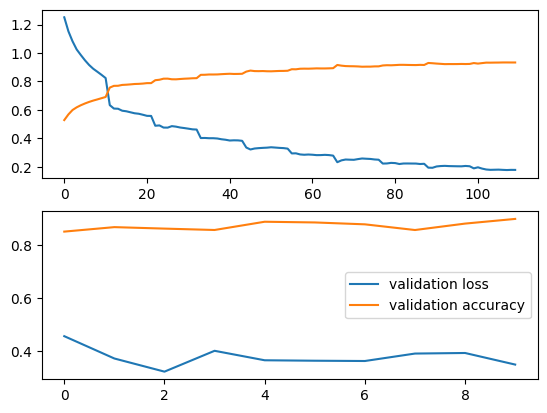

In [34]:
import matplotlib.pyplot as plt

# 새로운 그림 생성
fig = plt.figure(num=2)

# 그림에 서브플롯 추가 (2행 1열 중 첫 번째 서브플롯)
fig1 = fig.add_subplot(2, 1, 1)

# 그림에 서브플롯 추가 (2행 1열 중 두 번째 서브플롯)
fig2 = fig.add_subplot(2, 1, 2)

# 첫 번째 서브플롯에 훈련 손실과 정확도 그래프 추가
fig1.plot(total_loss_train, label='training loss')
fig1.plot(total_acc_train, label='training accuracy')

# 두 번째 서브플롯에 검증 손실과 정확도 그래프 추가
fig2.plot(total_loss_val, label='validation loss')
fig2.plot(total_acc_val, label='validation accuracy')

# 범례 추가
plt.legend()

# 그래프 출력
plt.show()

In [35]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    이 함수는 혼동 행렬(confusion matrix)을 출력하고 그래프로 나타내는 역할을 합니다.
    normalize를 True로 설정하여 정규화(normalization)를 적용할 수 있습니다.
    """
    # 혼동 행렬을 이미지로 보여줍니다.
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)  # 그래프의 제목을 설정합니다.
    plt.colorbar()  # 컬러바를 추가합니다.

    tick_marks = np.arange(len(classes))  # 클래스의 개수만큼 tick을 만듭니다.
    plt.xticks(tick_marks, classes, rotation=45)  # x축의 눈금 라벨을 설정하고 45도 회전시킵니다.
    plt.yticks(tick_marks, classes)  # y축의 눈금 라벨을 설정합니다.

    # 만약 정규화(normalize) 옵션이 True라면, 행렬의 각 값을 행의 합으로 나눠 정규화합니다.
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # 혼동 행렬의 최댓값의 절반을 임계값으로 설정하여 텍스트 색상을 결정합니다.
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")  # 임계값보다 크면 텍스트 색상을 하얀색, 작으면 검은색으로 합니다.

    plt.tight_layout()  # 그래프의 레이아웃을 조절하여 최적의 형태로 만듭니다.
    plt.ylabel('True label')  # y축 라벨을 설정합니다.
    plt.xlabel('Predicted label')  # x축 라벨을 설정합니다.

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


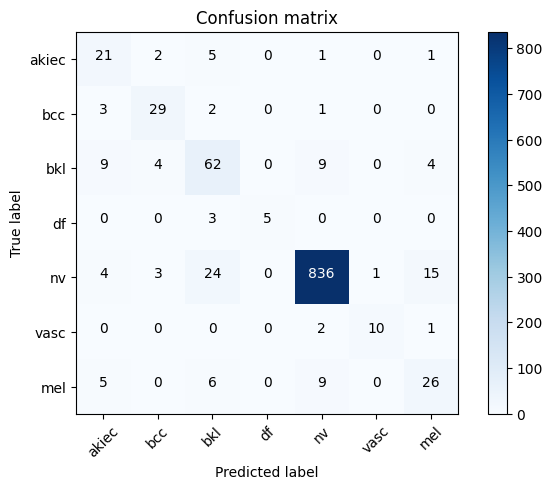

In [36]:
model.eval()
y_label = []  # 실제 라벨 저장 리스트
y_predict = []  # 예측 라벨 저장 리스트

# 평가 모드로 무작위 역전파를 비활성화하여 성능 향상
with torch.no_grad():
    for i, data in enumerate(val_loader):
        images, labels = data
        N = images.size(0)
        images = Variable(images).to(device)
        outputs = model(images)
        prediction = outputs.max(1, keepdim=True)[1]
        y_label.extend(labels.cpu().numpy())  # 실제 라벨을 리스트에 추가
        y_predict.extend(np.squeeze(prediction.cpu().numpy().T))  # 예측 라벨을 리스트에 추가

# 혼동 행렬 계산
confusion_mtx = confusion_matrix(y_label, y_predict)
# 혼동 행렬을 그래프로 시각화
plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc', 'mel']
plot_confusion_matrix(confusion_mtx, plot_labels)

In [37]:
# 분류 보고서 생성
report = classification_report(y_label, y_predict, target_names=plot_labels)
print(report)  # 보고서 출력

# classification_report 함수는 실제 라벨과 예측 라벨을 기반으로 분류 보고서를 생성합니다.
# target_names 매개변수에는 각 클래스의 이름(라벨)을 전달합니다.

              precision    recall  f1-score   support

       akiec       0.50      0.70      0.58        30
         bcc       0.76      0.83      0.79        35
         bkl       0.61      0.70      0.65        88
          df       1.00      0.62      0.77         8
          nv       0.97      0.95      0.96       883
        vasc       0.91      0.77      0.83        13
         mel       0.55      0.57      0.56        46

    accuracy                           0.90      1103
   macro avg       0.76      0.73      0.74      1103
weighted avg       0.91      0.90      0.90      1103



Text(0, 0.5, 'Fraction classified incorrectly')

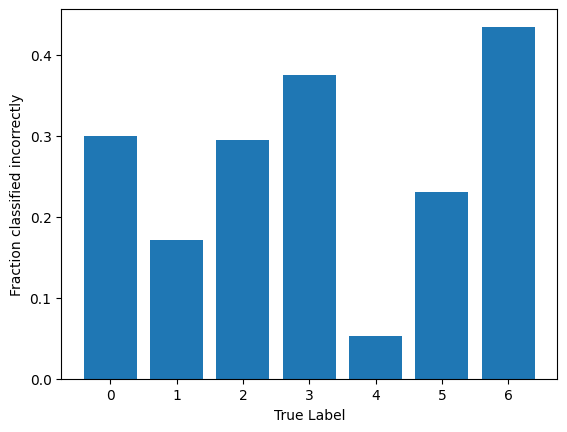

In [38]:
label_frac_error = 1 - np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)

# 각 클래스별 잘못 분류된 비율을 계산하여 label_frac_error 리스트에 저장
# np.diag(confusion_mtx)는 정확하게 분류된 개수를 나타내며,
# np.sum(confusion_mtx, axis=1)는 해당 클래스의 총 데이터 개수를 나타냅니다.

plt.bar(np.arange(7), label_frac_error)  # 막대 그래프로 잘못 분류된 비율을 표시
plt.xlabel('True Label')  # x축 라벨 설정
plt.ylabel('Fraction classified incorrectly')  # y축 라벨 설정

결론


다양한 네트워크 구조로 훈련을 시도해 보았습니다. Densenet-121을 사용할 때, 10 에포크 동안 7개 클래스에 대한 검증 세트의 평균 정확도가 92%에 도달했습니다. 모든 클래스에 대한 혼동 행렬을 계산하고 각 클래스의 F1 스코어를 계산했습니다. 이는 정밀도와 재현율을 모두 고려하는 더 포괄적인 지표로, 분류 모델의 성능을 평가하는 데 사용됩니다. 저희 모델은 F1 스코어 지표에서 90% 이상을 달성할 수 있었습니다.

제한된 시간으로 인해 모델 훈련에 많은 시간을 투자하지 못했습니다. 훈련 에포크를 늘리거나 모델 하이퍼파라미터를 조정하며 다양한 네트워크 시도를 통해 모델의 성능을 더 향상시킬 수 있을 것입니다.

다음 계획


동시에 이미지 데이터와 환자 케이스 데이터를 사용하는 방법은 이미지 데이터에서 특징을 추출하기 위해 CNN을 사용하고, 환자 의료 기록을 벡터로 변환하기 위해 XGBoost를 사용한 다음, 이를 CNN 네트워크의 전체 레이어 특징과 연결(concatenate)하는 것입니다. 두 개의 브랜치 네트워크를 동시에 학습시키기 위해 손실 함수를 사용합니다. 이는 광고 CTR 추정 작업에서 사용되는 방법과 유사한 접근입니다.